## Helpers

In [87]:
import pandas as pd
import os
from glob import glob

def load_and_merge_csvs(folder_path, method_name):
    """
    Load and merge all CSV files in a given folder.
    
    Parameters:
        folder_path (str): Path to the folder containing the CSV files.
        method_name (str): Name of the method to tag (e.g. "CoT").
    
    Returns:
        pd.DataFrame: Merged DataFrame with method and run columns.
    """
    # Find all CSV files in the folder
    csv_files = sorted(glob(os.path.join(folder_path, "*.csv")))

    dataframes = []
    for i, file_path in enumerate(csv_files):
        df = pd.read_csv(file_path)
        df["method"] = method_name
        df["run"] = i + 1
        dataframes.append(df)

    # Merge all into one DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)
    return merged_df

## Load cleaned data

### CoT

In [88]:
cot_all = load_and_merge_csvs("results/cot_few-shot_clean", method_name="CoT")
cot_all.tail()

,id,subject,ground_truth,predicted,correct,method,run
7195,questao_176,Mathematics,D,D,True,CoT,40
7196,questao_177,Mathematics,A,B,False,CoT,40
7197,questao_178,Mathematics,D,D,True,CoT,40
7198,questao_179,Mathematics,C,A,False,CoT,40
7199,questao_180,Mathematics,B,A,False,CoT,40


### CoVe

In [89]:
cove_all = load_and_merge_csvs("results/cove_few-shot_clean", method_name="CoVe")
cove_all.tail()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
7195,questao_176,Mathematics,D,D,True,D,CoVe,40
7196,questao_177,Mathematics,A,B,False,A,CoVe,40
7197,questao_178,Mathematics,D,D,True,D,CoVe,40
7198,questao_179,Mathematics,C,B,False,B,CoVe,40
7199,questao_180,Mathematics,B,A,False,A,CoVe,40


### Self-Refine

In [90]:
selfrefine_all = load_and_merge_csvs("results/self-refine_few-shot_clean", method_name="Self-Refine")
selfrefine_all.tail()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
7195,questao_176,Mathematics,D,D,True,D,Self-Refine,40
7196,questao_177,Mathematics,A,D,False,C,Self-Refine,40
7197,questao_178,Mathematics,D,A,False,D,Self-Refine,40
7198,questao_179,Mathematics,C,C,True,E,Self-Refine,40
7199,questao_180,Mathematics,B,A,False,A,Self-Refine,40


### Dataset Summary

In [91]:
print(f"{'Method':<15}{'Rows':<10}{'Columns':<10}{'Runs':<10}{'Unique IDs':<15}")
print("-" * 60)
print(f"{'CoT':<15}{cot_all.shape[0]:<10}{cot_all.shape[1]:<10}{cot_all['run'].nunique():<10}{cot_all['id'].nunique():<15}")
print(f"{'CoVe':<15}{cove_all.shape[0]:<10}{cove_all.shape[1]:<10}{cove_all['run'].nunique():<10}{cove_all['id'].nunique():<15}")
print(f"{'Self-Refine':<15}{selfrefine_all.shape[0]:<10}{selfrefine_all.shape[1]:<10}{selfrefine_all['run'].nunique():<10}{selfrefine_all['id'].nunique():<15}")


Method         Rows      Columns   Runs      Unique IDs     
------------------------------------------------------------
CoT            7200      7         40        180            
CoVe           7200      8         40        180            
Self-Refine    7200      8         40        180            


## Mean Accuracy per Run

#### Concat data from each method

In [92]:
accuracy_by_run = pd.concat([cot_all, cove_all, selfrefine_all], ignore_index=True)

#### Calculate mean accuracy per method and test run

In [93]:
run_stats = accuracy_by_run.groupby(["method", "run"])["correct"].mean().reset_index()

print("Per-run Accuracy:")
print(run_stats.pivot(index="run", columns="method", values="correct").round(3))

Per-run Accuracy:
method    CoT   CoVe  Self-Refine
run                              
1       0.672  0.672        0.700
2       0.722  0.683        0.694
3       0.661  0.650        0.678
4       0.706  0.672        0.706
5       0.711  0.728        0.722
6       0.711  0.650        0.683
7       0.694  0.639        0.700
8       0.700  0.667        0.700
9       0.706  0.644        0.683
10      0.706  0.650        0.700
11      0.722  0.689        0.683
12      0.683  0.683        0.700
13      0.694  0.683        0.667
14      0.717  0.661        0.656
15      0.711  0.689        0.672
16      0.678  0.689        0.672
17      0.717  0.667        0.694
18      0.667  0.694        0.667
19      0.700  0.644        0.711
20      0.711  0.706        0.694
21      0.711  0.656        0.678
22      0.728  0.683        0.672
23      0.689  0.656        0.689
24      0.694  0.683        0.711
25      0.728  0.667        0.678
26      0.694  0.667        0.650
27      0.700  0.694        0.

## 📊 General Accuracy: General Mean and Standard Deviation

In [94]:
# Compute the number of unique runs per method from the original data.
runs_count = accuracy_by_run.groupby("method")["run"].nunique().reset_index(name="runs")
print("Runs count per method:")
print(runs_count)

# Group by method, subject, and run to compute the per-run average correctness.
df_grouped = accuracy_by_run.groupby(["method", "subject", "run"])["correct"].mean().reset_index()

# Aggregate across runs (across all subjects) for each method.
df_overall = df_grouped.groupby("method")["correct"].agg(["mean", "std"]).reset_index()
df_overall.rename(columns={"mean": "accuracy_mean_all", "std": "accuracy_std_all"}, inplace=True)

# Merge the runs count into df_overall.
df_overall = df_overall.merge(runs_count, on="method")

print("\nOverall Accuracy with Number of Runs:")
df_overall

Runs count per method:
        method  runs
0          CoT    40
1         CoVe    40
2  Self-Refine    40

Overall Accuracy with Number of Runs:


,method,accuracy_mean_all,accuracy_std_all,runs
0,CoT,0.703750,0.189968,40
1,CoVe,0.672917,0.205645,40
2,Self-Refine,0.685694,0.193422,40


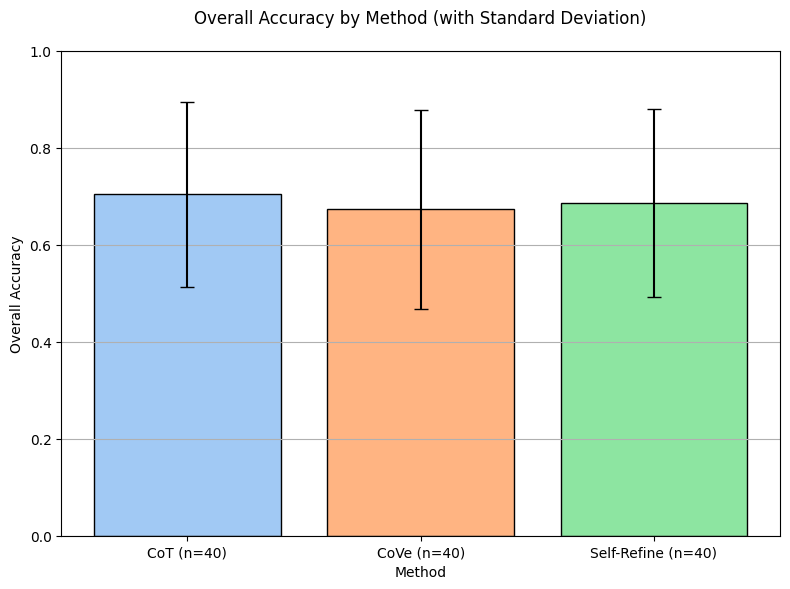

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get pastel colors
pastel_colors = sns.color_palette("pastel", n_colors=len(df_overall))

plt.figure(figsize=(8, 6))
bars = plt.bar(
    df_overall["method"],
    df_overall["accuracy_mean_all"],
    yerr=df_overall["accuracy_std_all"],
    capsize=5,
    color=pastel_colors,
    edgecolor="black"
)

plt.xlabel("Method")
plt.ylabel("Overall Accuracy")
plt.title("Overall Accuracy by Method (with Standard Deviation)", pad=20)
plt.ylim(0, 1)

# Create x-axis labels with run count
new_labels = [f"{m} (n={r})" for m, r in zip(df_overall["method"], df_overall["runs"])]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)

plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Accuracy per Subject: Mean and Standard Deviation

### Calculate Mean and Standard Deviation

#### Aggregate per Subject

In [96]:
df_agg = (
    accuracy_by_run.groupby(["method", "subject", "run"])["correct"]
    .mean()  # Average correctness per run
    .groupby(["method", "subject"])
    .agg(accuracy_mean="mean", accuracy_std="std")  # Aggregate across runs
    .reset_index()
)

#### Mean

In [97]:
df_accuracy_mean_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_mean")

df_accuracy_mean_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.955000,0.803889,0.495,0.561111
CoVe,0.934444,0.787778,0.415,0.554444
Self-Refine,0.942222,0.785556,0.475,0.540000


#### Standard Deviation

In [98]:
df_accuracy_std_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_std")

df_accuracy_std_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.023864,0.027968,0.059328,0.040805
CoVe,0.031407,0.042686,0.042220,0.038964
Self-Refine,0.022951,0.045722,0.052222,0.046450


#### Mean and Standard Deviation

In [99]:
df_agg["accuracy_formatted"] = df_agg.apply(
    lambda row: f"{row['accuracy_mean']:.3f} ± {row['accuracy_std']:.3f}", axis=1
)

df_accuracy_mean_std_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_formatted")

df_accuracy_mean_std_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.955 ± 0.024,0.804 ± 0.028,0.495 ± 0.059,0.561 ± 0.041
CoVe,0.934 ± 0.031,0.788 ± 0.043,0.415 ± 0.042,0.554 ± 0.039
Self-Refine,0.942 ± 0.023,0.786 ± 0.046,0.475 ± 0.052,0.540 ± 0.046


### 📊 Accuracy per Subject: Mean and Std

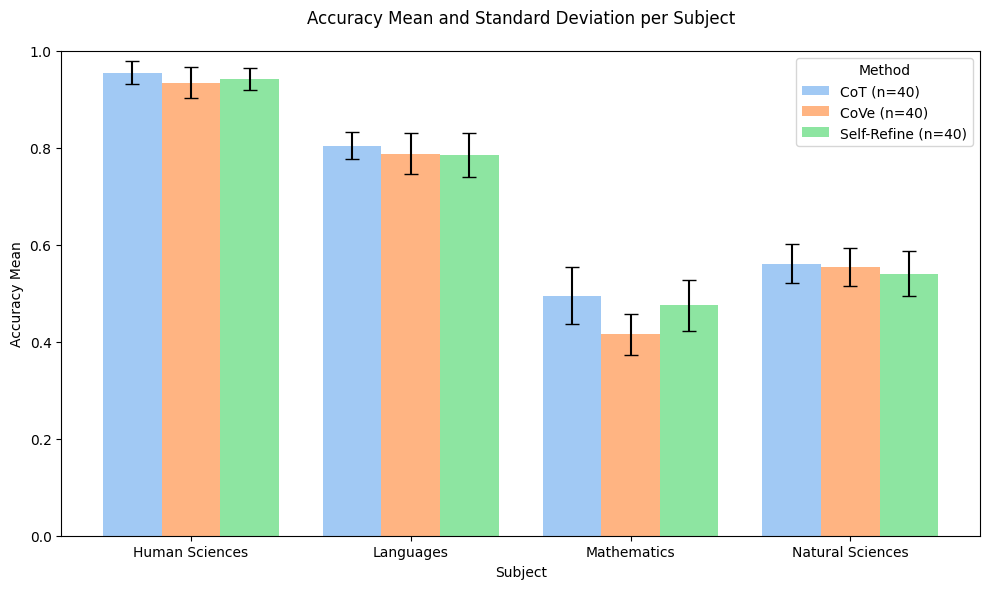

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # for pastel palette

# Compute the overall number of runs per method
runs_count_overall = accuracy_by_run.groupby("method")["run"].nunique()
runs_dict = runs_count_overall.to_dict()

# Extract subjects and methods
subjects = df_accuracy_mean_per_subject.columns.tolist()
methods = df_accuracy_mean_per_subject.index.tolist()

# Create positions on the x-axis for each subject
n_subjects = len(subjects)
x = np.arange(n_subjects)
bar_width = 0.8 / len(methods)

# Get pastel color palette with as many colors as methods
pastel_colors = sns.color_palette("pastel", n_colors=len(methods))

plt.figure(figsize=(10, 6))

# Plot bars per method with error bars
for i, method in enumerate(methods):
    means = df_accuracy_mean_per_subject.loc[method].values
    stds = df_accuracy_std_per_subject.loc[method].values
    offset = (i - (len(methods) - 1) / 2) * bar_width
    label_with_runs = f"{method} (n={runs_dict.get(method, '?')})"
    
    plt.bar(
        x + offset,
        means,
        bar_width,
        yerr=stds,
        capsize=5,
        label=label_with_runs,
        color=pastel_colors[i]
    )

# Final plot adjustments
plt.xticks(x, subjects)
plt.xlabel("Subject")
plt.ylabel("Accuracy Mean")
plt.title("Accuracy Mean and Standard Deviation per Subject", pad=20)
plt.ylim(0, 1)
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Exploratory Analysis: Feedback Effects in CoVe and Self-Refine

#### Helpers

In [101]:
# --- Color mapping ---
custom_colors = {
    'Improvement': '#9EC6F3',          
    'Regression': '#FEBE8C',           
    'Consistently Correct': '#B6E2A1', 
    'Consistently Incorrect': '#F7A4A4' 
}

# --- Classification function ---
def classify_answer_change(row):
    initial_correct = row['initial_answer'] == row['ground_truth']
    final_correct = row['predicted'] == row['ground_truth']
    if not initial_correct and final_correct:
        return 'Improvement'
    elif initial_correct and not final_correct:
        return 'Regression'
    elif initial_correct and final_correct:
        return 'Consistently Correct'
    else:
        return 'Consistently Incorrect'

# --- Preprocessing function ---
def prepare_data(df, method_label):
    df = df.copy()
    df['result_category'] = df.apply(classify_answer_change, axis=1)
    df['method_label'] = method_label
    return df

# --- Plotting helper for both plots per method ---
def plot_method_row(df, method_label, axs_row):
    # Plot 1: Answer Transitions (Bar Plot)
    counts = df['result_category'].value_counts().reindex([
        'Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect'
    ], fill_value=0)
    colors = [custom_colors[cat] for cat in counts.index]
    axs_row[0].bar(counts.index, counts.values, color=colors)
    axs_row[0].set_title(f"Answer Transitions – {method_label}")
    axs_row[0].set_ylabel("Number of Answers")
    axs_row[0].grid(axis='y')
    
    # Remove x-axis tick labels
    axs_row[0].set_xticks([])       # removes the ticks
    axs_row[0].set_xticklabels([])  # removes the labels


    # Plot 2: Stacked Bar per Subject
    subject_counts = (
        df.groupby(['subject', 'result_category'])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=[
            'Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect'
        ], fill_value=0)
    )
    subject_counts.plot(
        kind='bar',
        stacked=True,
        ax=axs_row[1],
        color=[custom_colors[col] for col in subject_counts.columns],
        legend=False
    )
    axs_row[1].set_title(f"Feedback Result Categories per Subject – {method_label}")
    axs_row[1].set_ylabel("Number of Questions")
    axs_row[1].set_xlabel("Subject")
    axs_row[1].tick_params(axis='x', rotation=0)
    axs_row[1].grid(axis='y')

#### Prepare data

In [102]:
cove_runs = cove_all['run'].nunique()
selfrefine_runs = selfrefine_all['run'].nunique()

cove_all_classified = prepare_data(cove_all, f"Chain-of-Verification ({cove_runs} runs)")
selfrefine_all_classified = prepare_data(selfrefine_all, f"SELF-REFINE ({selfrefine_runs} runs)")

#### 📊 Feedback Effects by Method

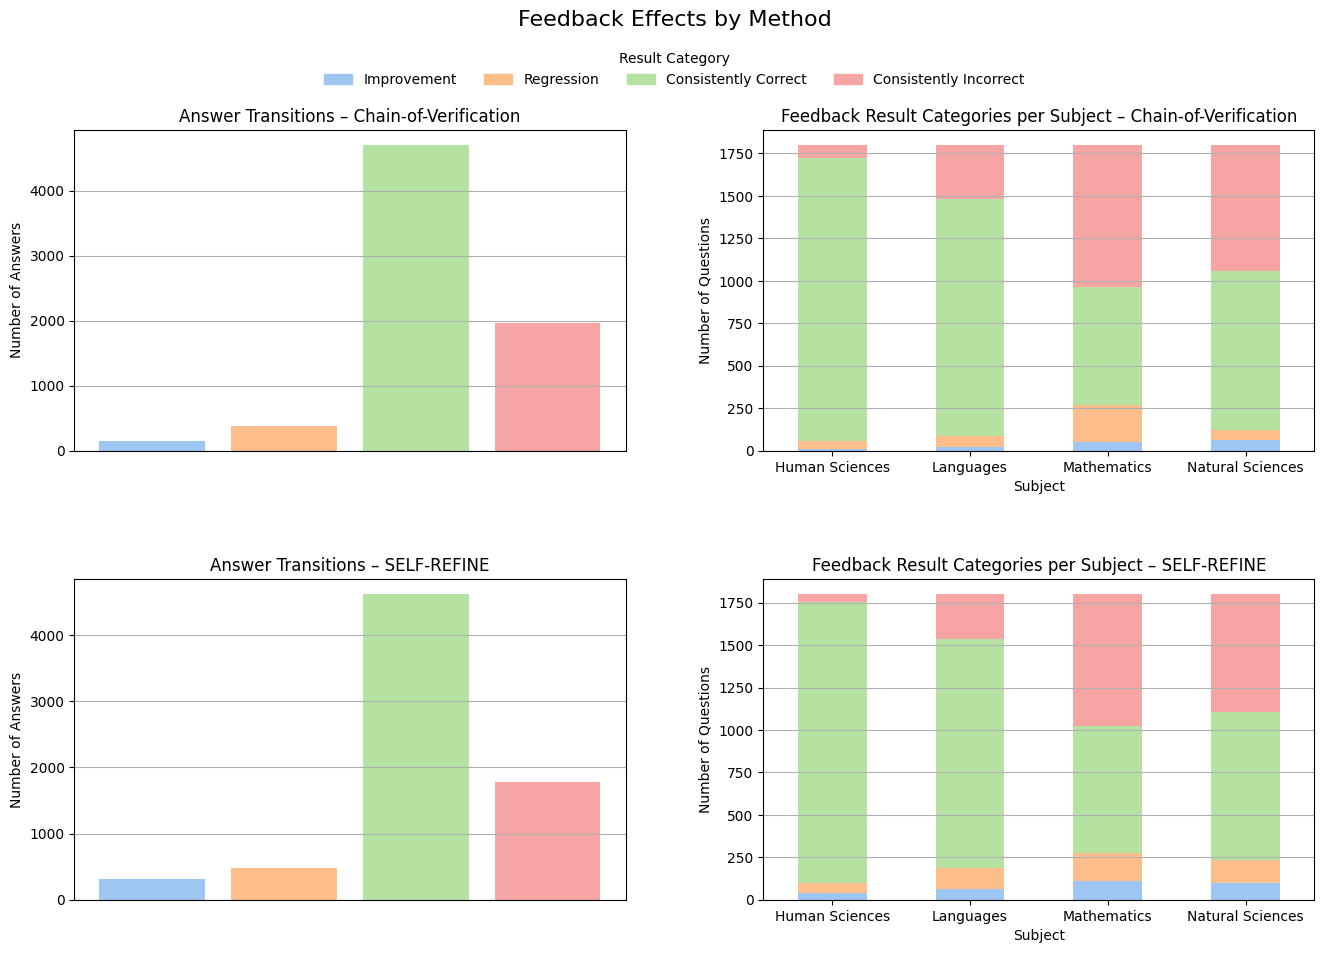

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create 2x2 plot layout ---
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

plot_method_row(cove_all_classified, "Chain-of-Verification", axs[0])
plot_method_row(selfrefine_all_classified, "SELF-REFINE", axs[1])

# --- Shared legend ---
# Create manual legend to ensure correct colors
from matplotlib.patches import Patch
legend_handles = [
    Patch(color=custom_colors[k], label=k)
    for k in ['Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect']
]
fig.legend(
    handles=legend_handles,
    title="Result Category",
    loc='upper center',
    bbox_to_anchor=(0.5, 0.97),
    ncol=4,
    frameon=False
)

fig.suptitle("Feedback Effects by Method", fontsize=16, y=1)
plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.25)
plt.show()

#### 📊 Feedback effects by Subject

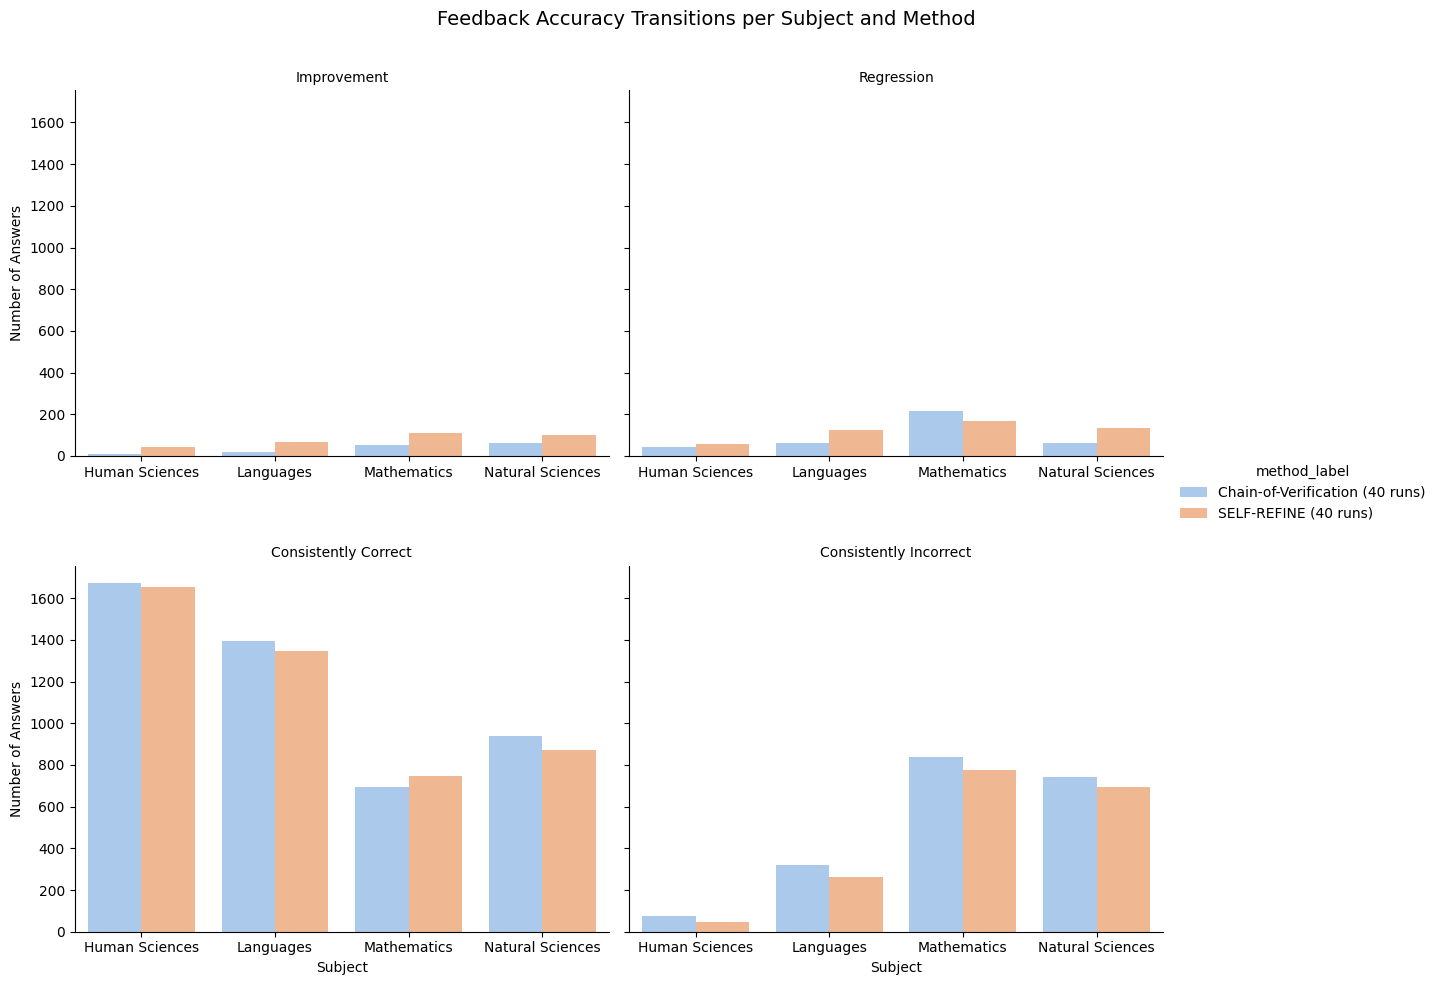

In [104]:
# --- Combine for plotting ---
combined_classified_df = pd.concat([cove_all_classified, selfrefine_all_classified], ignore_index=True)

# --- Grouped counts per subject, method, result category ---
subject_summary = (
    combined_classified_df
    .groupby(['subject', 'method_label', 'result_category'])
    .size()
    .reset_index(name='count')
)

# --- Consistent category order ---
category_order = ['Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect']

# --- Plot using Seaborn catplot ---
plot = sns.catplot(
    data=subject_summary,
    x='subject', y='count',
    hue='method_label',
    col='result_category',
    kind='bar',
    col_order=category_order,
    palette='pastel', 
    col_wrap=2,
    height=5, aspect=1.2
)

plot.set_titles("{col_name}")
plot.set_axis_labels("Subject", "Number of Answers")
plot.fig.subplots_adjust(top=0.9, hspace=0.3)
plot.fig.suptitle("Feedback Accuracy Transitions per Subject and Method", fontsize=14)

# Rotate x labels
for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        label.set_horizontalalignment('center')
    ax.xaxis.set_tick_params(labelbottom=True)

plt.show()

## 📈 Statistical Analysis - Consistency

### General

Conduct pairwise McNemar’s tests to determine whether differences in consistency between prompting methods are statistically significant.

**Null hypothesis (H₀)**: There is no difference in consistency between the two methods.

**Alternative hypothesis (H₁)**: There is a difference in consistency between the two methods.

The tests revealed statistically significant differences between CoT and both CoVe (p < 0.001) and Self-Refine (p < 0.001). No significant difference was found between CoVe and Self-Refine (p = 1.000), indicating similar behavior between those two methods.

In [105]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

# Make copies of original data
cot_df = cot_all.copy()
cove_df = cove_all.copy()
selfrefine_df = selfrefine_all.copy()

# Helper function: mark questions as consistent if only one answer was ever predicted
def compute_consistency_flags(df):
    return df.groupby("id")["predicted"].nunique().apply(lambda x: 1 if x == 1 else 0)

# Create binary consistency flags (1 = consistent, 0 = inconsistent)
cot_consistency = compute_consistency_flags(cot_df).rename("CoT")
cove_consistency = compute_consistency_flags(cove_df).rename("CoVe")
selfrefine_consistency = compute_consistency_flags(selfrefine_df).rename("SelfRefine")

# Combine flags into one dataframe for comparison
consistency_flags = pd.concat([cot_consistency, cove_consistency, selfrefine_consistency], axis=1)

# Count overall consistency per method
print("Consistency per method:")
print(consistency_flags.sum() / len(consistency_flags))

# Pairwise McNemar tests
def run_mcnemar(df, method1, method2):
    # Contingency table
    both = df[[method1, method2]]
    table = pd.crosstab(both[method1], both[method2])
    
    # Ensure it's a 2x2 matrix
    table = table.reindex(index=[0,1], columns=[0,1], fill_value=0)
    
    print(f"\nContingency table ({method1} vs {method2}):\n{table}")
    
    result = mcnemar(table, exact=True)
    print(f"\nMcNemar's test ({method1} vs {method2}): p-value = {result.pvalue:.4f}")
    return result.pvalue

# Run McNemar tests between methods
run_mcnemar(consistency_flags, "CoT", "CoVe")
run_mcnemar(consistency_flags, "CoT", "SelfRefine")
run_mcnemar(consistency_flags, "CoVe", "SelfRefine")

Consistency per method:
CoT           0.472222
CoVe          0.294444
SelfRefine    0.300000
dtype: float64

Contingency table (CoT vs CoVe):
CoVe   0   1
CoT         
0     90   5
1     37  48

McNemar's test (CoT vs CoVe): p-value = 0.0000

Contingency table (CoT vs SelfRefine):
SelfRefine   0   1
CoT               
0           91   4
1           35  50

McNemar's test (CoT vs SelfRefine): p-value = 0.0000

Contingency table (CoVe vs SelfRefine):
SelfRefine    0   1
CoVe               
0           110  17
1            16  37

McNemar's test (CoVe vs SelfRefine): p-value = 1.0000


np.float64(1.0)

### 📊 Subject-wise Consistency

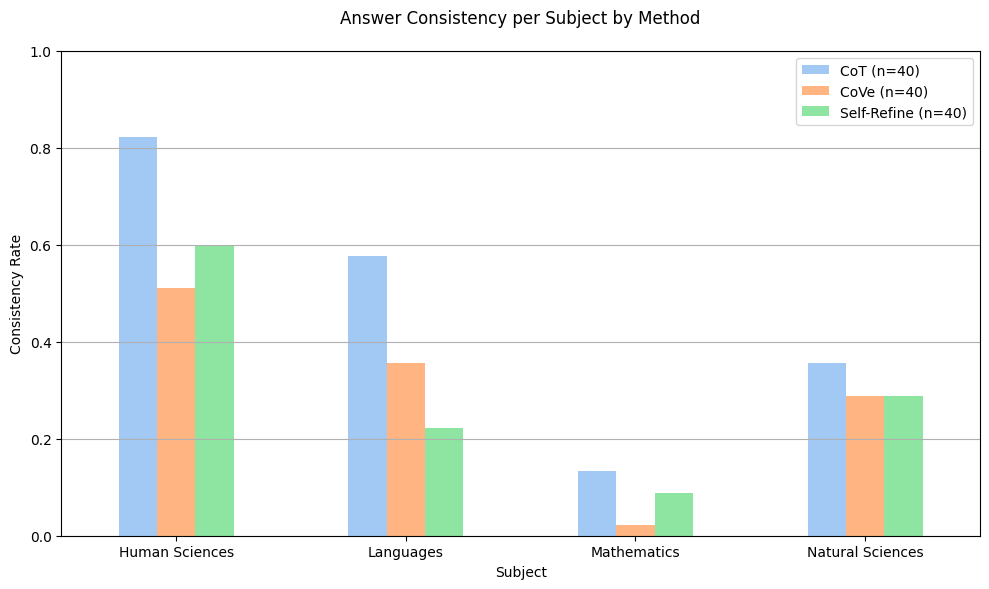

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Required for pastel palette

# --- Step 1: Copy original datasets ---
cot_df = cot_all.copy()
cove_df = cove_all.copy()
selfrefine_df = selfrefine_all.copy()

# --- Step 2: Determine number of runs per method ---
n_cot = cot_df['run'].nunique()
n_cove = cove_df['run'].nunique()
n_selfrefine = selfrefine_df['run'].nunique()

# --- Step 3: Compute per-subject consistency ---
def compute_subject_consistency(df, method_label):
    grouped = df.groupby(['id', 'subject'])['predicted'].nunique().reset_index()
    grouped['consistent'] = grouped['predicted'].apply(lambda x: 1 if x == 1 else 0)
    consistency_by_subject = grouped.groupby('subject')['consistent'].mean().reset_index()
    consistency_by_subject.columns = ['subject', method_label]
    return consistency_by_subject

# Create labeled method names with run counts
cot_label = f'CoT (n={n_cot})'
cove_label = f'CoVe (n={n_cove})'
selfrefine_label = f'Self-Refine (n={n_selfrefine})'

# Compute consistency
cot_subj = compute_subject_consistency(cot_df, cot_label)
cove_subj = compute_subject_consistency(cove_df, cove_label)
selfrefine_subj = compute_subject_consistency(selfrefine_df, selfrefine_label)

# --- Step 4: Merge data ---
merged_consistency = cot_subj.merge(cove_subj, on='subject').merge(selfrefine_subj, on='subject')
merged_consistency.set_index('subject', inplace=True)

# --- Step 5: Plot with pastel colors ---
pastel_colors = sns.color_palette("pastel", n_colors=3)
ax = merged_consistency.plot(
    kind='bar',
    figsize=(10, 6),
    color=pastel_colors
)

ax.set_title("Answer Consistency per Subject by Method", pad=20)
ax.set_ylabel("Consistency Rate")
ax.set_xlabel("Subject")
ax.set_ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [107]:
from statsmodels.stats.contingency_tables import mcnemar
import itertools

# Step 1: Build consistency flags per question per subject
def get_consistency_flags_per_subject(df, method_name):
    grouped = df.groupby(['id', 'subject'])['predicted'].nunique().reset_index()
    grouped['consistent'] = grouped['predicted'].apply(lambda x: 1 if x == 1 else 0)
    grouped = grouped[['id', 'subject', 'consistent']]
    grouped.columns = ['id', 'subject', method_name]
    return grouped

# Create individual consistency flags
cot_flags = get_consistency_flags_per_subject(cot_df, 'CoT')
cove_flags = get_consistency_flags_per_subject(cove_df, 'CoVe')
selfrefine_flags = get_consistency_flags_per_subject(selfrefine_df, 'SelfRefine')

# Merge all into a single DataFrame
merged_flags = cot_flags.merge(cove_flags, on=['id', 'subject']).merge(selfrefine_flags, on=['id', 'subject'])

# Step 2: Run McNemar test for each subject and each method pair
subjects = merged_flags['subject'].unique()
method_pairs = [('CoT', 'CoVe'), ('CoT', 'SelfRefine'), ('CoVe', 'SelfRefine')]

for subject in subjects:
    print(f"\n📘 Subject: {subject}")
    df_sub = merged_flags[merged_flags['subject'] == subject]
    
    for m1, m2 in method_pairs:
        tab = pd.crosstab(df_sub[m1], df_sub[m2])
        tab = tab.reindex(index=[0,1], columns=[0,1], fill_value=0)
        
        print(f"\n→ {m1} vs {m2} Contingency Table:\n{tab}")
        result = mcnemar(tab, exact=True)
        print(f"p-value = {result.pvalue:.4f}")



📘 Subject: Languages

→ CoT vs CoVe Contingency Table:
CoVe   0   1
CoT         
0     16   3
1     13  13
p-value = 0.0213

→ CoT vs SelfRefine Contingency Table:
SelfRefine   0  1
CoT              
0           17  2
1           18  8
p-value = 0.0004

→ CoVe vs SelfRefine Contingency Table:
SelfRefine   0  1
CoVe             
0           26  3
1            9  7
p-value = 0.1460

📘 Subject: Natural Sciences

→ CoT vs CoVe Contingency Table:
CoVe   0   1
CoT         
0     27   2
1      5  11
p-value = 0.4531

→ CoT vs SelfRefine Contingency Table:
SelfRefine   0   1
CoT               
0           28   1
1            4  12
p-value = 0.3750

→ CoVe vs SelfRefine Contingency Table:
SelfRefine   0   1
CoVe              
0           29   3
1            3  10
p-value = 1.0000

📘 Subject: Mathematics

→ CoT vs CoVe Contingency Table:
CoVe   0  1
CoT        
0     39  0
1      5  1
p-value = 0.0625

→ CoT vs SelfRefine Contingency Table:
SelfRefine   0  1
CoT              
0           38  1


## 📈 Statistical Analysis - General Performance

### Q1: Is there a difference between the methods' performance?

**Null Hypothesis (H₀)**: The median accuracies for the three methods (CoT, CoVe, Self-Refine) are equal.

**Alternative Hypothesis (H₁)**: At least one method has a different median accuracy compared to the others.


#### Compute per run accuracy

In [108]:
import pandas as pd

# Creating copies of the original datasets
cot = cot_all.copy()
cove = cove_all.copy()
selfrefine = selfrefine_all.copy() 

# For CoT dataset
df_cot = cot.groupby(["subject", "run"], as_index=False)["correct"].mean()
df_cot["method"] = "CoT"

# For CoVe dataset
df_cove = cove.groupby(["subject", "run"], as_index=False)["correct"].mean()
df_cove["method"] = "CoVe"

# For Self-Refine dataset
df_selfrefine = selfrefine.groupby(["subject", "run"], as_index=False)["correct"].mean()
df_selfrefine["method"] = "Self-Refine"

# Combine all methods into one DataFrame
df_grouped = pd.concat([df_cot, df_cove, df_selfrefine], ignore_index=True)
print(df_grouped.tail())


              subject  run   correct       method
475  Natural Sciences   36  0.666667  Self-Refine
476  Natural Sciences   37  0.555556  Self-Refine
477  Natural Sciences   38  0.533333  Self-Refine
478  Natural Sciences   39  0.511111  Self-Refine
479  Natural Sciences   40  0.577778  Self-Refine


#### Check for normality

In [109]:
from scipy.stats import shapiro

print("Shapiro–Wilk Test for Normality:")
for method, group in df_grouped.groupby("method"):
    stat, p = shapiro(group["correct"])
    print(f"{method}: W = {stat:.4f}, p-value = {p:.4f}")


Shapiro–Wilk Test for Normality:
CoT: W = 0.8983, p-value = 0.0000
CoVe: W = 0.9108, p-value = 0.0000
Self-Refine: W = 0.8929, p-value = 0.0000


#### Check for Homogeneity of Variances

In [120]:
from scipy.stats import levene

cot_scores = df_grouped[df_grouped["method"] == "CoT"]["correct"]
cove_scores = df_grouped[df_grouped["method"] == "CoVe"]["correct"]
selfrefine_scores = df_grouped[df_grouped["method"] == "Self-Refine"]["correct"]

stat, p = levene(cot_scores, cove_scores, selfrefine_scores)
print(f"Levene's test: Statistic = {stat:.4f}, p-value = {p:.4f}")


Levene's test: Statistic = 1.2022, p-value = 0.3014


#### Run the Kruskal–Wallis Test

Interpretation of p-value:

If the p-value is greater than the common significance level of 0.05, then there is not enough evidence to reject the null hypothesis.

Conclusion:
You fail to reject the null hypothesis.
In practical terms, the differences in overall accuracy among the three methods are not statistically significant based on your data.



In [121]:
from scipy.stats import kruskal

# Extract accuracy values for each method
cot_scores = df_grouped[df_grouped["method"] == "CoT"]["correct"]
cove_scores = df_grouped[df_grouped["method"] == "CoVe"]["correct"]
selfrefine_scores = df_grouped[df_grouped["method"] == "Self-Refine"]["correct"]

# Run the Kruskal-Wallis test
h_stat, p_value = kruskal(cot_scores, cove_scores, selfrefine_scores)

print("Kruskal–Wallis H statistic:", h_stat)
print("Kruskal–Wallis p-value:", p_value)


Kruskal–Wallis H statistic: 3.7021827883048917
Kruskal–Wallis p-value: 0.15706565220154006


## 📈 Statiscal Analysis - Subject-wise Performance

#### Calculate accuracy per run and subject

In [122]:
accuracy_per_run_and_subject = (
    accuracy_by_run
    .groupby(['method', 'run', 'subject'])['correct']
    .mean()
    .reset_index(name='accuracy')
)

### Q1: Does any method perform better than the others in a given subject?

In [123]:
accuracy_per_run_and_subject = (
    accuracy_by_run
    .groupby(['method', 'run', 'subject'])['correct']
    .mean()
    .reset_index(name='accuracy')
)

In [124]:
from scipy.stats import kruskal
import pandas as pd

# Step 1: Run Kruskal-Wallis tests and collect stats
subject_results = []

for subject in accuracy_per_run_and_subject["subject"].unique():
    data = accuracy_per_run_and_subject[accuracy_per_run_and_subject["subject"] == subject]

    cot_scores = data[data["method"] == "CoT"]["accuracy"]
    cove_scores = data[data["method"] == "CoVe"]["accuracy"]
    selfrefine_scores = data[data["method"] == "Self-Refine"]["accuracy"]

    h_stat, p_value = kruskal(cot_scores, cove_scores, selfrefine_scores)

    subject_results.append({
        "Subject": subject,
        "CoT Mean": cot_scores.mean(),
        "CoT Std": cot_scores.std(),
        "CoVe Mean": cove_scores.mean(),
        "CoVe Std": cove_scores.std(),
        "Self-Refine Mean": selfrefine_scores.mean(),
        "Self-Refine Std": selfrefine_scores.std(),
        "Kruskal-Wallis H": h_stat,
        "p-value (raw)": p_value,
    })

# Step 2: Convert to DataFrame and preserve a numeric copy
df_subject_kruskal = pd.DataFrame(subject_results)
df_subject_kruskal_numeric = df_subject_kruskal.copy()  # <- ADD THIS LINE

# Step 3: Format p-values with significance stars
def format_p_with_stars(p):
    if p <= 0.001:
        return f"{p:.4g} ***"
    elif p <= 0.01:
        return f"{p:.4g} **"
    elif p <= 0.05:
        return f"{p:.4g} *"
    else:
        return f"{p:.4g}"

df_subject_kruskal["p-value"] = df_subject_kruskal["p-value (raw)"].apply(format_p_with_stars)

# Step 4: Combine mean ± std into formatted strings
df_subject_kruskal["CoT Accuracy"] = df_subject_kruskal.apply(
    lambda row: f"{row['CoT Mean']:.3f} ± {row['CoT Std']:.3f}", axis=1)

df_subject_kruskal["CoVe Accuracy"] = df_subject_kruskal.apply(
    lambda row: f"{row['CoVe Mean']:.3f} ± {row['CoVe Std']:.3f}", axis=1)

df_subject_kruskal["Self-Refine Accuracy"] = df_subject_kruskal.apply(
    lambda row: f"{row['Self-Refine Mean']:.3f} ± {row['Self-Refine Std']:.3f}", axis=1)

# Step 5: Select and reorder columns for clean display
df_subject_kruskal = df_subject_kruskal[[
    "Subject",
    "CoT Accuracy", "CoVe Accuracy", "Self-Refine Accuracy",
    "Kruskal-Wallis H", "p-value"
]]

# Display the final table
df_subject_kruskal


,Subject,CoT Accuracy,CoVe Accuracy,Self-Refine Accuracy,Kruskal-Wallis H,p-value
0,Human Sciences,0.955 ± 0.024,0.934 ± 0.031,0.942 ± 0.023,10.425922,0.005446 **
1,Languages,0.804 ± 0.028,0.788 ± 0.043,0.786 ± 0.046,5.508679,0.06365
2,Mathematics,0.495 ± 0.059,0.415 ± 0.042,0.475 ± 0.052,37.652330,6.667e-09 ***
3,Natural Sciences,0.561 ± 0.041,0.554 ± 0.039,0.540 ± 0.046,5.743476,0.0566


In [125]:
print(df_subject_kruskal.columns.tolist())


['Subject', 'CoT Accuracy', 'CoVe Accuracy', 'Self-Refine Accuracy', 'Kruskal-Wallis H', 'p-value']


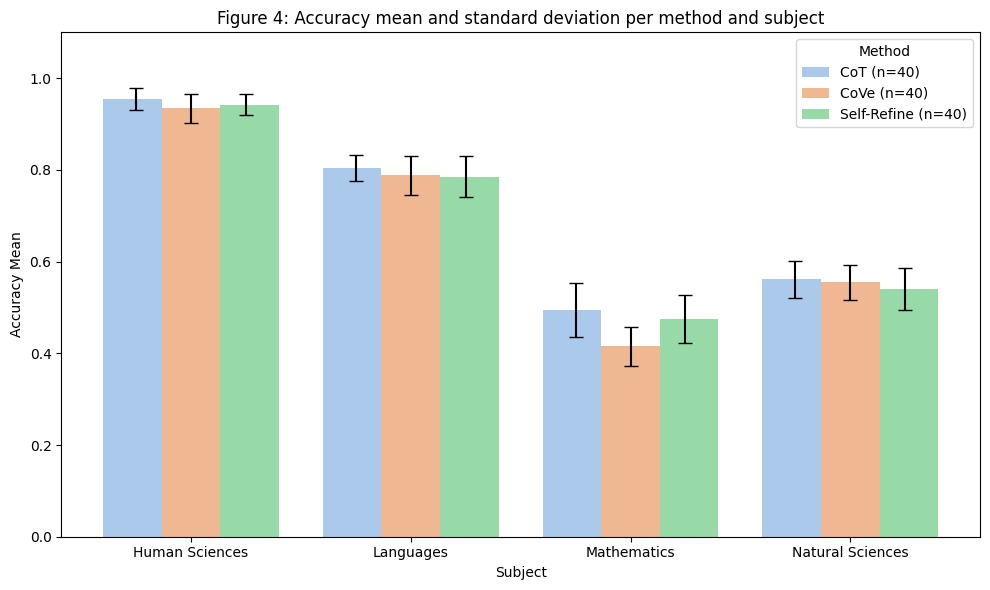

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare melted DataFrame for plotting with error bars
df_plot = pd.DataFrame({
    "Subject": list(df_subject_kruskal_numeric["Subject"]) * 3,
    "Method": ["CoT"] * 4 + ["CoVe"] * 4 + ["Self-Refine"] * 4,
    "Accuracy": (
        list(df_subject_kruskal_numeric["CoT Mean"]) +
        list(df_subject_kruskal_numeric["CoVe Mean"]) +
        list(df_subject_kruskal_numeric["Self-Refine Mean"])
    ),
    "Std": (
        list(df_subject_kruskal_numeric["CoT Std"]) +
        list(df_subject_kruskal_numeric["CoVe Std"]) +
        list(df_subject_kruskal_numeric["Self-Refine Std"])
    )
})

# Add sample size to legend labels
df_plot["Method"] = df_plot["Method"].map({
    "CoT": "CoT (n=40)",
    "CoVe": "CoVe (n=40)",
    "Self-Refine": "Self-Refine (n=40)"
})

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_plot,
    x="Subject", y="Accuracy",
    hue="Method", palette="pastel",
    errorbar=None, capsize=0.05
)

# Add manual error bars
method_offsets = {
    "CoT (n=40)": -0.25,
    "CoVe (n=40)": 0.0,
    "Self-Refine (n=40)": 0.25
}
subjects = df_plot["Subject"].unique()
for i, row in df_plot.iterrows():
    x = list(subjects).index(row["Subject"])
    offset = method_offsets[row["Method"]]
    ax.errorbar(x + offset, row["Accuracy"], yerr=row["Std"], fmt='none', c='black', capsize=5)

# Final formatting
plt.ylim(0, 1.1)
plt.ylabel("Accuracy Mean")
plt.xlabel("Subject")
plt.legend(title="Method")
plt.title("Figure 4: Accuracy mean and standard deviation per method and subject")
plt.tight_layout()
plt.show()


### Q2: Would CoVe and Self-Refine have performed better if they had simply chosen the initial answer, rather than refining to the final prediction?

**Null Hypothesis H₀**: Final accuracy is equal to or better than initial accuracy

**Alternative Hypothesis H₁**: Final accuracy is worse than initial accuracy

##### Compute run-level accuracies (per subject and method)

In [127]:
# Function to compute accuracy per run and subject
def get_run_level_accuracy(df, method_label):
    return (
        df.groupby(["subject", "run"], group_keys=False)
        .apply(lambda x: pd.Series({
            "initial_accuracy": (x["initial_answer"] == x["ground_truth"]).mean(),
            "final_accuracy": (x["predicted"] == x["ground_truth"]).mean(),
            "method": method_label
        }), include_groups=False)
        .reset_index()
    )

# Apply to both datasets
cove_runs_df = get_run_level_accuracy(cove_all, "CoVe")
selfrefine_runs_df = get_run_level_accuracy(selfrefine_all, "Self-Refine")

# Combine into a single DataFrame
runs_df = pd.concat([cove_runs_df, selfrefine_runs_df], ignore_index=True)

#### Test: Is the initial accuracy statistically significantly better than the final accuracy?

In [128]:
from scipy.stats import ttest_rel, wilcoxon, shapiro

results_improvement = []

for (method, subject), group in runs_df.groupby(["method", "subject"]):
    diffs = group["initial_accuracy"] - group["final_accuracy"]
    # Normality test
    _, p_normality = shapiro(diffs)

    # One-sided test: is initial > final?
    if p_normality > 0.05:
        test_used = "one-sided paired t-test"
        stat, p_value = ttest_rel(group["initial_accuracy"], group["final_accuracy"], alternative="greater")
    else:
        test_used = "one-sided Wilcoxon"
        stat, p_value = wilcoxon(group["initial_accuracy"], group["final_accuracy"], alternative="greater")

    results_improvement.append({
        "method": method,
        "subject": subject,
        "normality_p": p_normality,
        "test_used": test_used,
        "p_value": p_value,
        "significant": p_value < 0.05
    })

improvement_df = pd.DataFrame(results_improvement)

# Count number of unique runs per method/subject
run_counts = runs_df.groupby(["method", "subject"])["run"].nunique().reset_index()
run_counts.columns = ["method", "subject", "n_runs"]

# Merge into the improvement_df
improvement_df = improvement_df.merge(run_counts, on=["method", "subject"])

improvement_df

,method,subject,normality_p,test_used,p_value,significant,n_runs
0,CoVe,Human Sciences,0.000210,one-sided Wilcoxon,1.049818e-04,True,40
1,CoVe,Languages,0.074402,one-sided paired t-test,2.744357e-05,True,40
2,CoVe,Mathematics,0.195119,one-sided paired t-test,3.431039e-13,True,40
3,CoVe,Natural Sciences,0.017626,one-sided Wilcoxon,3.437467e-01,False,40
4,Self-Refine,Human Sciences,0.014433,one-sided Wilcoxon,5.981206e-02,False,40
5,Self-Refine,Languages,0.017444,one-sided Wilcoxon,9.795968e-05,True,40
6,Self-Refine,Mathematics,0.055846,one-sided paired t-test,1.179069e-04,True,40
7,Self-Refine,Natural Sciences,0.081444,one-sided paired t-test,1.082055e-02,True,40


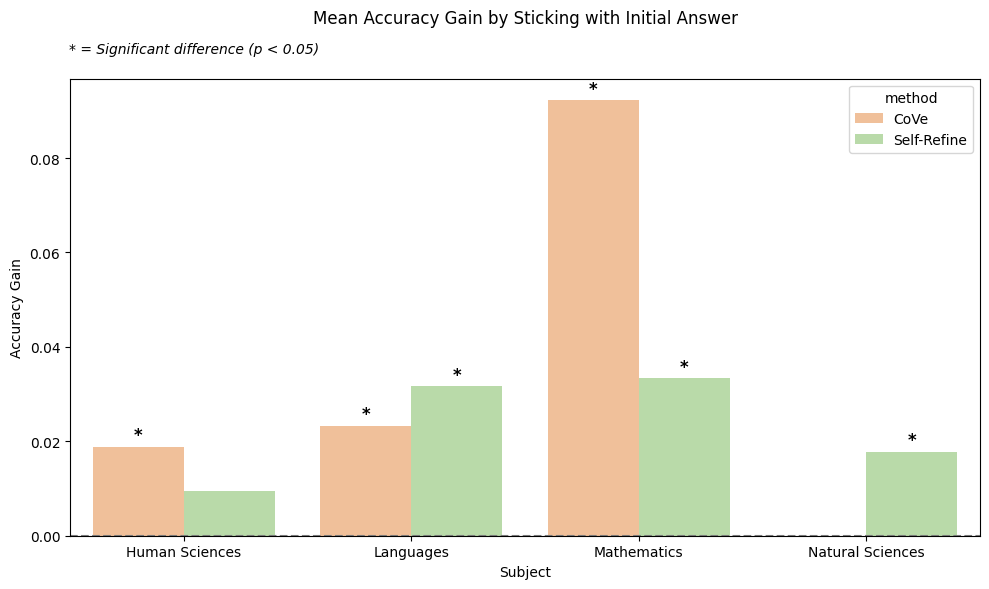

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


# 1. Compute mean difference per method and subject
runs_df["diff"] = runs_df["initial_accuracy"] - runs_df["final_accuracy"]
mean_diffs = (
    runs_df.groupby(["method", "subject"])["diff"]
    .mean()
    .reset_index(name="mean_diff")
)

# 2. Merge with improvement_df to get significance and n_runs
plot_df = improvement_df.merge(mean_diffs, on=["method", "subject"])

# 3. Get number of runs per method (assumed consistent across subjects)
method_runs = plot_df.groupby("method")["n_runs"].first().to_dict()
hue_labels = [f"{method} (n={method_runs[method]})" for method in plot_df["method"].unique()]

custom_palette = {
    "CoVe": "#FEBE8C",        
    "Self-Refine": "#B6E2A1"  
}

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df,
    x="subject",
    y="mean_diff",
    hue="method",
    palette=custom_palette
)

# 4. Add significance markers (*) one-to-one with bars
for bar, (_, row) in zip(ax.patches, plot_df.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    if row["significant"]:
        ax.text(x, y + 0.0005, "*", ha='center', va='bottom', fontsize=12, fontweight="bold")

# 5. Formatting
plt.axhline(0, color="gray", linestyle="--")
plt.title("Mean Accuracy Gain by Sticking with Initial Answer", pad=40)
plt.ylabel("Accuracy Gain")
plt.xlabel("Subject")


# Custom legend with run counts

# Add separate note for significance marker
ax.text(
    -0.001, 1.05,  # X and Y position in axes coordinates
    "* = Significant difference (p < 0.05)",
    transform=ax.transAxes,
    ha='left',
    va='bottom',
    fontsize=10,
    style='italic',
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')
)


plt.tight_layout()
plt.show()
